In [2]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

In [3]:
def sample_from_disjoint_interval(size):
    coin_flip = np.random.rand(size) < 0.5
    left = np.random.uniform(-1.5, -0.5, size)
    right = np.random.uniform(0.5, 1.5, size)
    return np.where(coin_flip, left, right)

def generate_connection_matrix(p, s):
    #s is the probability of a connection, if you 
    #want the sparsity to be the same as in the paper 
    #set s=1/(p-1)

    # Generate binary adjacency matrix (lower triangle only)
    rand_matrix = np.random.binomial(1, s, size=(p, p))
    lower_triangle_mask = np.tril(np.ones((p, p)), k=-1)
    adj_matrix = rand_matrix * lower_triangle_mask

    # Count how many 1s (non-zero connections) to sample that many weights
    num_connections = int(np.sum(adj_matrix))

    # Generate random weights from the disjoint interval
    weights = sample_from_disjoint_interval(num_connections)

    # Fill the weights into the matrix (vectorized)
    connection_matrix = np.zeros((p, p))
    connection_matrix[adj_matrix == 1] = weights

    return connection_matrix

def sample_uniform_noise(n, p, variances):
    # Uniform distribution on [-sqrt(3 * var), sqrt(3 * var)] has variance = var
    e = np.zeros((n, p))
    for i in range(p):
        scale = np.sqrt(3 * variances[i])
        e[:, i] = np.random.uniform(low=-scale, high=scale, size=n)
    return e



import numpy as np

def generate_dataset(E, B, permutation=None):
    """
    Generate dataset X from external influences E and connection matrix B,
    with Gaussian shift and optional column permutation.
    
    Parameters:
    - E: (n, p) matrix of external influences
    - B: (p, p) connection strength matrix
    - permutation: list or array of length p (optional). If None, a random permutation is generated.
    
    Returns:
    - X_perm: the permuted data matrix (n, p)
    - means: Gaussian shifts applied to each variable (p,)
    - permutation: the permutation used (to apply consistently across groups)
    """
    n, p = E.shape
    I = np.eye(p)
    A_inv = np.linalg.inv(I - B).T
    X = E @ A_inv  # Step: X = E (I - B)^-1

    # Step: Add Gaussian mean shift (N(0, 4) → std = 2)
    means = np.random.normal(loc=0, scale=2.0, size=p)
    X += means  # Broadcast to shift each variable

    # Step: Apply consistent variable permutation
    if permutation is None:
        permutation = np.random.permutation(p)

    X_perm = X[:, permutation]  # Permute columns
    
    return X_perm, means, permutation





In [4]:
p=5
s=0.5
n=10000
B=generate_connection_matrix(p, s)

In [5]:
B

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -1.22783452,  0.        ,  0.        ,  0.        ],
       [-1.22093661,  0.80845321,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.25755641,  0.53452325,  0.        ]])

In [199]:
variances = np.random.uniform(low=1,high=3,size=p)

In [200]:
E = sample_uniform_noise(n, 5, variances)

In [201]:
X, m, perm_ = generate_dataset(E, B, permutation=None)

In [203]:
m

array([ 0.492608  , -0.4916362 , -0.05906891,  1.63714322,  2.03941558])

In [204]:
perm_

array([4, 2, 0, 1, 3])

## Estimating back

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

In [205]:
#now we can retrieve the causal graph given the generated dataset.
model = lingam.DirectLiNGAM()
model.fit(X)

In [217]:
inverse_perm = np.argsort(perm_)
B_est_original_order = model.adjacency_matrix_[inverse_perm, :][:, inverse_perm]

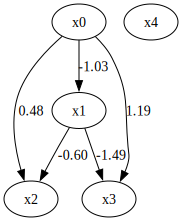

In [218]:
make_dot(B_est_original_order)

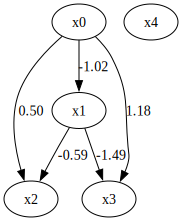

In [208]:
make_dot(B)

In [209]:
B

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.01544738,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.50055843, -0.58787966,  0.        ,  0.        ,  0.        ],
       [ 1.18449243, -1.49077568,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

## Matrix Perturbation


In [17]:

import random

def perturb_adjacency_matrix(matrix, n=1, mode='both', weight_range=(-1.5, -0.5)):
    """
    Perturbs a weighted adjacency matrix by adding/removing edges,
    preserving causal order (i.e., j < i for edge j → i).

    Parameters:
    - matrix: np.ndarray, square weighted adjacency matrix
    - n: number of edges to add/remove
    - mode: 'add', 'remove', or 'both'
    - weight_range: tuple, range of weights to assign when adding edges

    Returns:
    - new_matrix: np.ndarray, perturbed matrix
    """

    new_matrix = matrix.copy()
    num_nodes = new_matrix.shape[0]
    
    # Collect removable and addable edges
    removable_edges = [(i, j) for i in range(num_nodes) for j in range(i) if new_matrix[i, j] != 0]
    addable_edges = [(i, j) for i in range(num_nodes) for j in range(i) if new_matrix[i, j] == 0]
    
    if mode in ['remove', 'both']:
        to_remove = random.sample(removable_edges, min(n, len(removable_edges)))
        for i, j in to_remove:
            new_matrix[i, j] = 0.0

    if mode in ['add', 'both']:
        to_add = random.sample(addable_edges, min(n, len(addable_edges)))
        for i, j in to_add:
            weight = random.uniform(*weight_range)
            new_matrix[i, j] = weight

    return new_matrix


import networkx as nx

def get_causal_order(matrix):
    G = nx.DiGraph()
    num_nodes = matrix.shape[0]

    # Add edges from matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if matrix[i, j] != 0:
                G.add_edge(j, i)  # edge from parent j to child i

    # Compute topological sort
    try:
        causal_order = list(nx.topological_sort(G))
        return causal_order
    except nx.NetworkXUnfeasible:
        raise ValueError("The graph contains cycles and is not a DAG.")



In [7]:
p=5
s=0.5
n=10000
B=generate_connection_matrix(p, s)

In [8]:
model = lingam.DirectLiNGAM()
model._adjacency_matrix=B

In [12]:
model._causal_order

In [18]:
get_causal_order(B)

[0, 1, 2, 3, 4]

In [20]:
B_perturbed=perturb_adjacency_matrix(B, 1, 'remove')

In [22]:
B_perturbed

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.35493197,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.12777073,  0.        ,  0.71115245,  0.        ,  0.        ]])

In [21]:
get_causal_order(B_perturbed)

[0, 2, 3, 4]